# Data visualisation of the dev dataset
Exploration of the dev datasets

In [1]:
import string
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from urllib.parse import urlparse
import seaborn as sns
import re

In [2]:
dev = pd.read_csv("data/dev_cleaned_final.csv")

## Useful functions
*print_cloud* will print a word cloud of the frequent words contained in extracted texts

*plot_top_n* will provide a bar plot of the n most frequent words

*text_cleaning* will remove the punctuations and lowercase the text

Each of these functions remove stopwords beforehand

In [3]:
def print_cloud(text):
    counted_items = Counter(text).most_common()
    wordcloud = WordCloud(width = 1920,height = 1080, stopwords = STOPWORDS).generate_from_frequencies(dict(counted_items))
    fig = plt.figure(figsize = (40, 30))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [4]:
def plot_top_n(content, title, item_name="word", cmap="viridis", n=10):
    counted_items = Counter(content)
    top_n = counted_items.most_common(n)
    items, count = zip(*top_n)
    color = plt.get_cmap(cmap)(np.linspace(1, 0, n))
    mpl.style.use('seaborn')
    plt.title(title)
    plt.xlabel('Count')
    plt.ylabel(item_name)
    plt.barh(items, count, color=color)

In [5]:
def text_cleaning(row):
    x = row["Corrected_text"]
    if not x or (type(x) == float and math.isnan(x)):
        return None
    cleaned = x.translate(str.maketrans('', '', string.punctuation))
    cleaned = " ".join(cleaned.lower().split())
    return cleaned

Remove urls and copyrights from text content

In [6]:
url_regex = r"(?i)(https?:\/\/)*(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&\/\/=]*)"
dev.Corrected_text = dev.Corrected_text.replace(url_regex, '', regex=True)

In [7]:
copyright_regex = r"(?i)(imgflip|memecenter|we\s*know\s*memes?)\s*$"
dev.Corrected_text = dev.Corrected_text.replace(copyright_regex, '', regex=True)

In [8]:
dev.Corrected_text = dev.Corrected_text.str.strip()

In [9]:
dev.to_csv("data/dev_text_cleaned_final.csv", index=False)

In [10]:
dev["extracted_words"] = dev.apply(lambda x: text_cleaning(x), axis=1)

In [11]:
def get_meme_source(row):
    x = row["Image_URL"]
    parsed_url = urlparse(x)
    return parsed_url.netloc

In [12]:
dev["source"] = dev.apply(lambda x: get_meme_source(x), axis=1)

In [13]:
def get_word_count(row):
    x = row["extracted_words"]
    word_count = len(x.split())
    return word_count

In [14]:
dev["word_count"] = dev.apply(lambda x: get_word_count(x), axis=1)

### Global overview

In [15]:
content = ' '.join(dev.extracted_words)
filtered_words = [word for word in content.split() if word not in STOPWORDS]

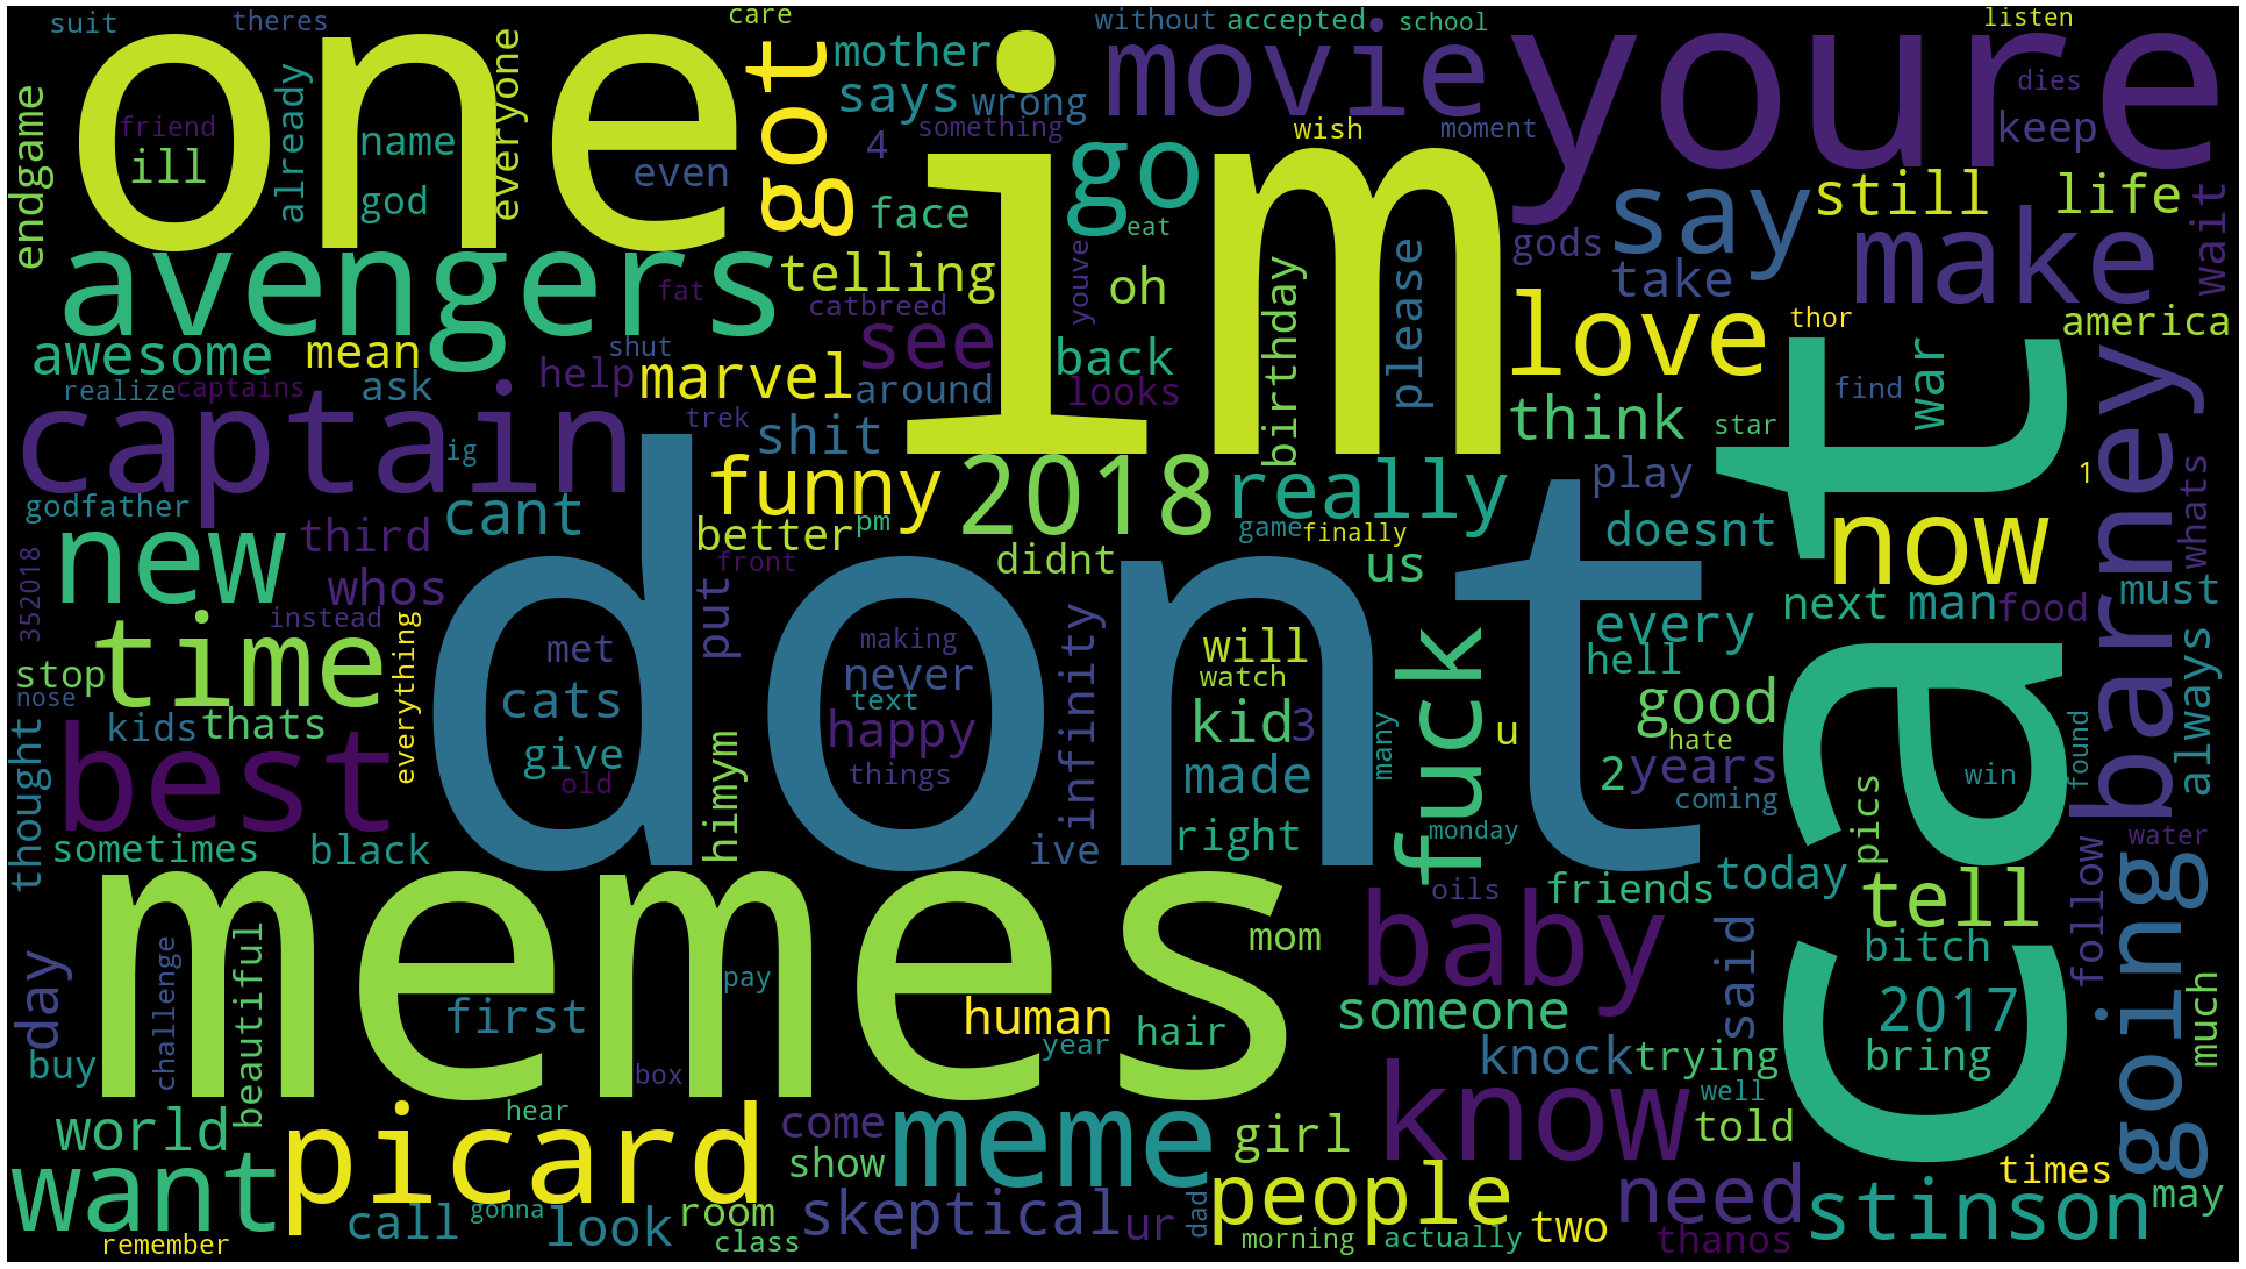

In [16]:
print_cloud(filtered_words)

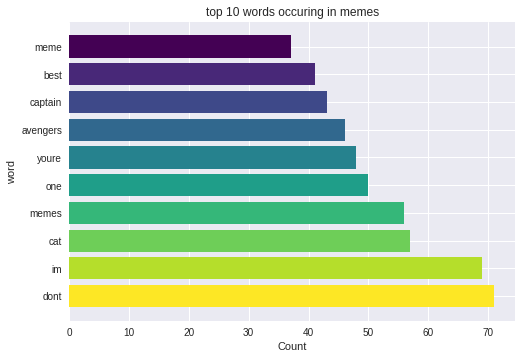

In [17]:
plot_top_n(filtered_words, "top 10 words occuring in memes", n=10)

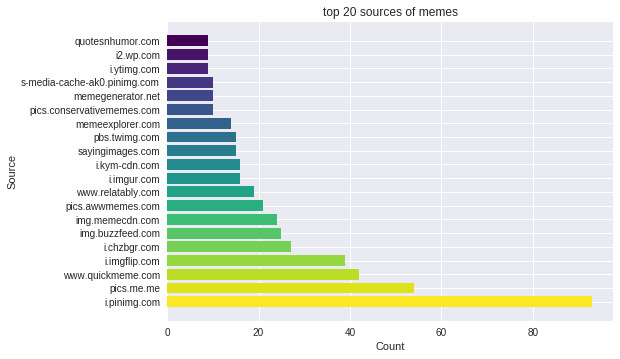

In [18]:
content = dev.source.values
plot_top_n(content, "top 20 sources of memes", item_name="Source", n=20)

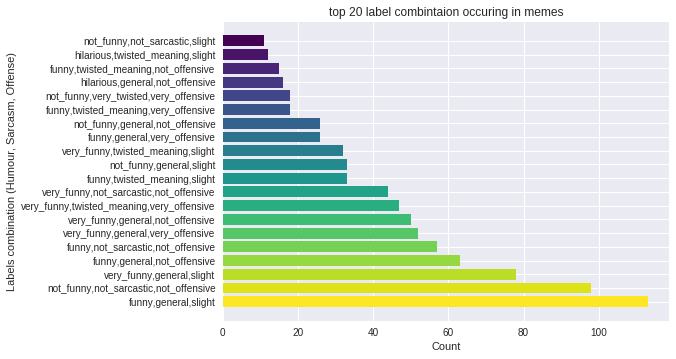

In [19]:
content = dev[['Humour', 'Sarcasm', 'Offense']].apply(lambda x: ','.join(x), axis=1)
plot_top_n(content.values, "top 20 label combintaion occuring in memes", item_name="Labels combination (Humour, Sarcasm, Offense)", n=20)

In [20]:
to_grp = dev[["Humour", "Sarcasm", "Offense"]]

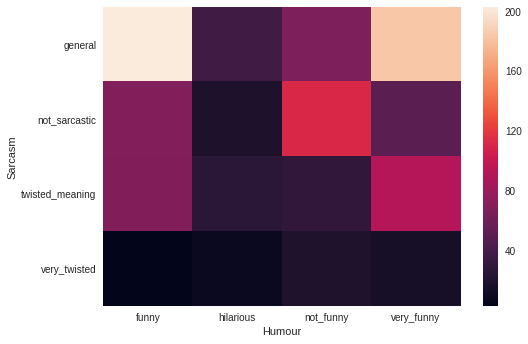

In [21]:
grp = to_grp.rename(columns={"Offense": "count"})
grp = grp.groupby(["Humour", "Sarcasm"]).count()
grp = grp.reset_index().pivot(columns="Humour",index="Sarcasm",values="count")
sns.heatmap(grp)

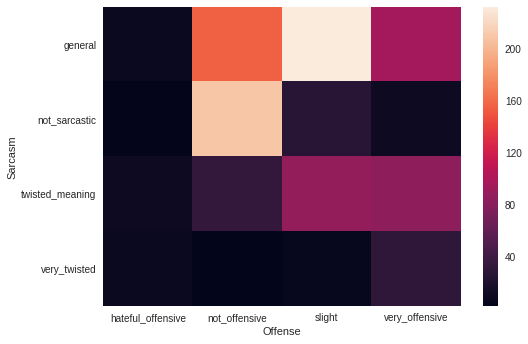

In [22]:
grp = to_grp.rename(columns={"Humour": "count"})
grp = grp.groupby(["Offense", "Sarcasm"]).count()
grp = grp.reset_index().pivot(columns="Offense",index="Sarcasm",values="count")
sns.heatmap(grp)

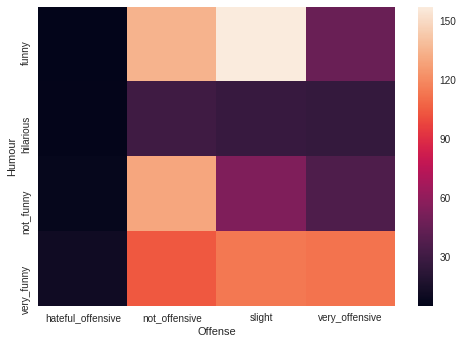

In [23]:
grp = to_grp.rename(columns={"Sarcasm": "count"})
grp = grp.groupby(["Offense", "Humour"]).count()
grp = grp.reset_index().pivot(columns="Offense",index="Humour",values="count")
sns.heatmap(grp)

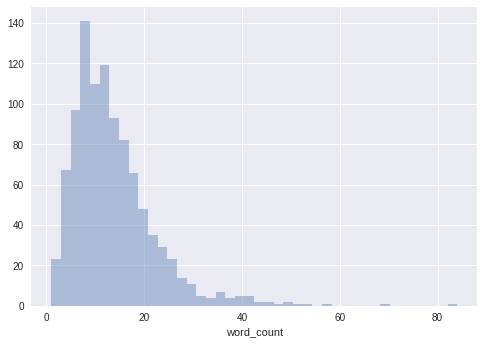

In [24]:
sns.distplot(dev["word_count"], kde=False)

### Humour label

In [25]:
content = ' '.join(dev[dev["Humour"] != "not_funny"].extracted_words)
filtered_words = [word for word in content.split() if word not in STOPWORDS]

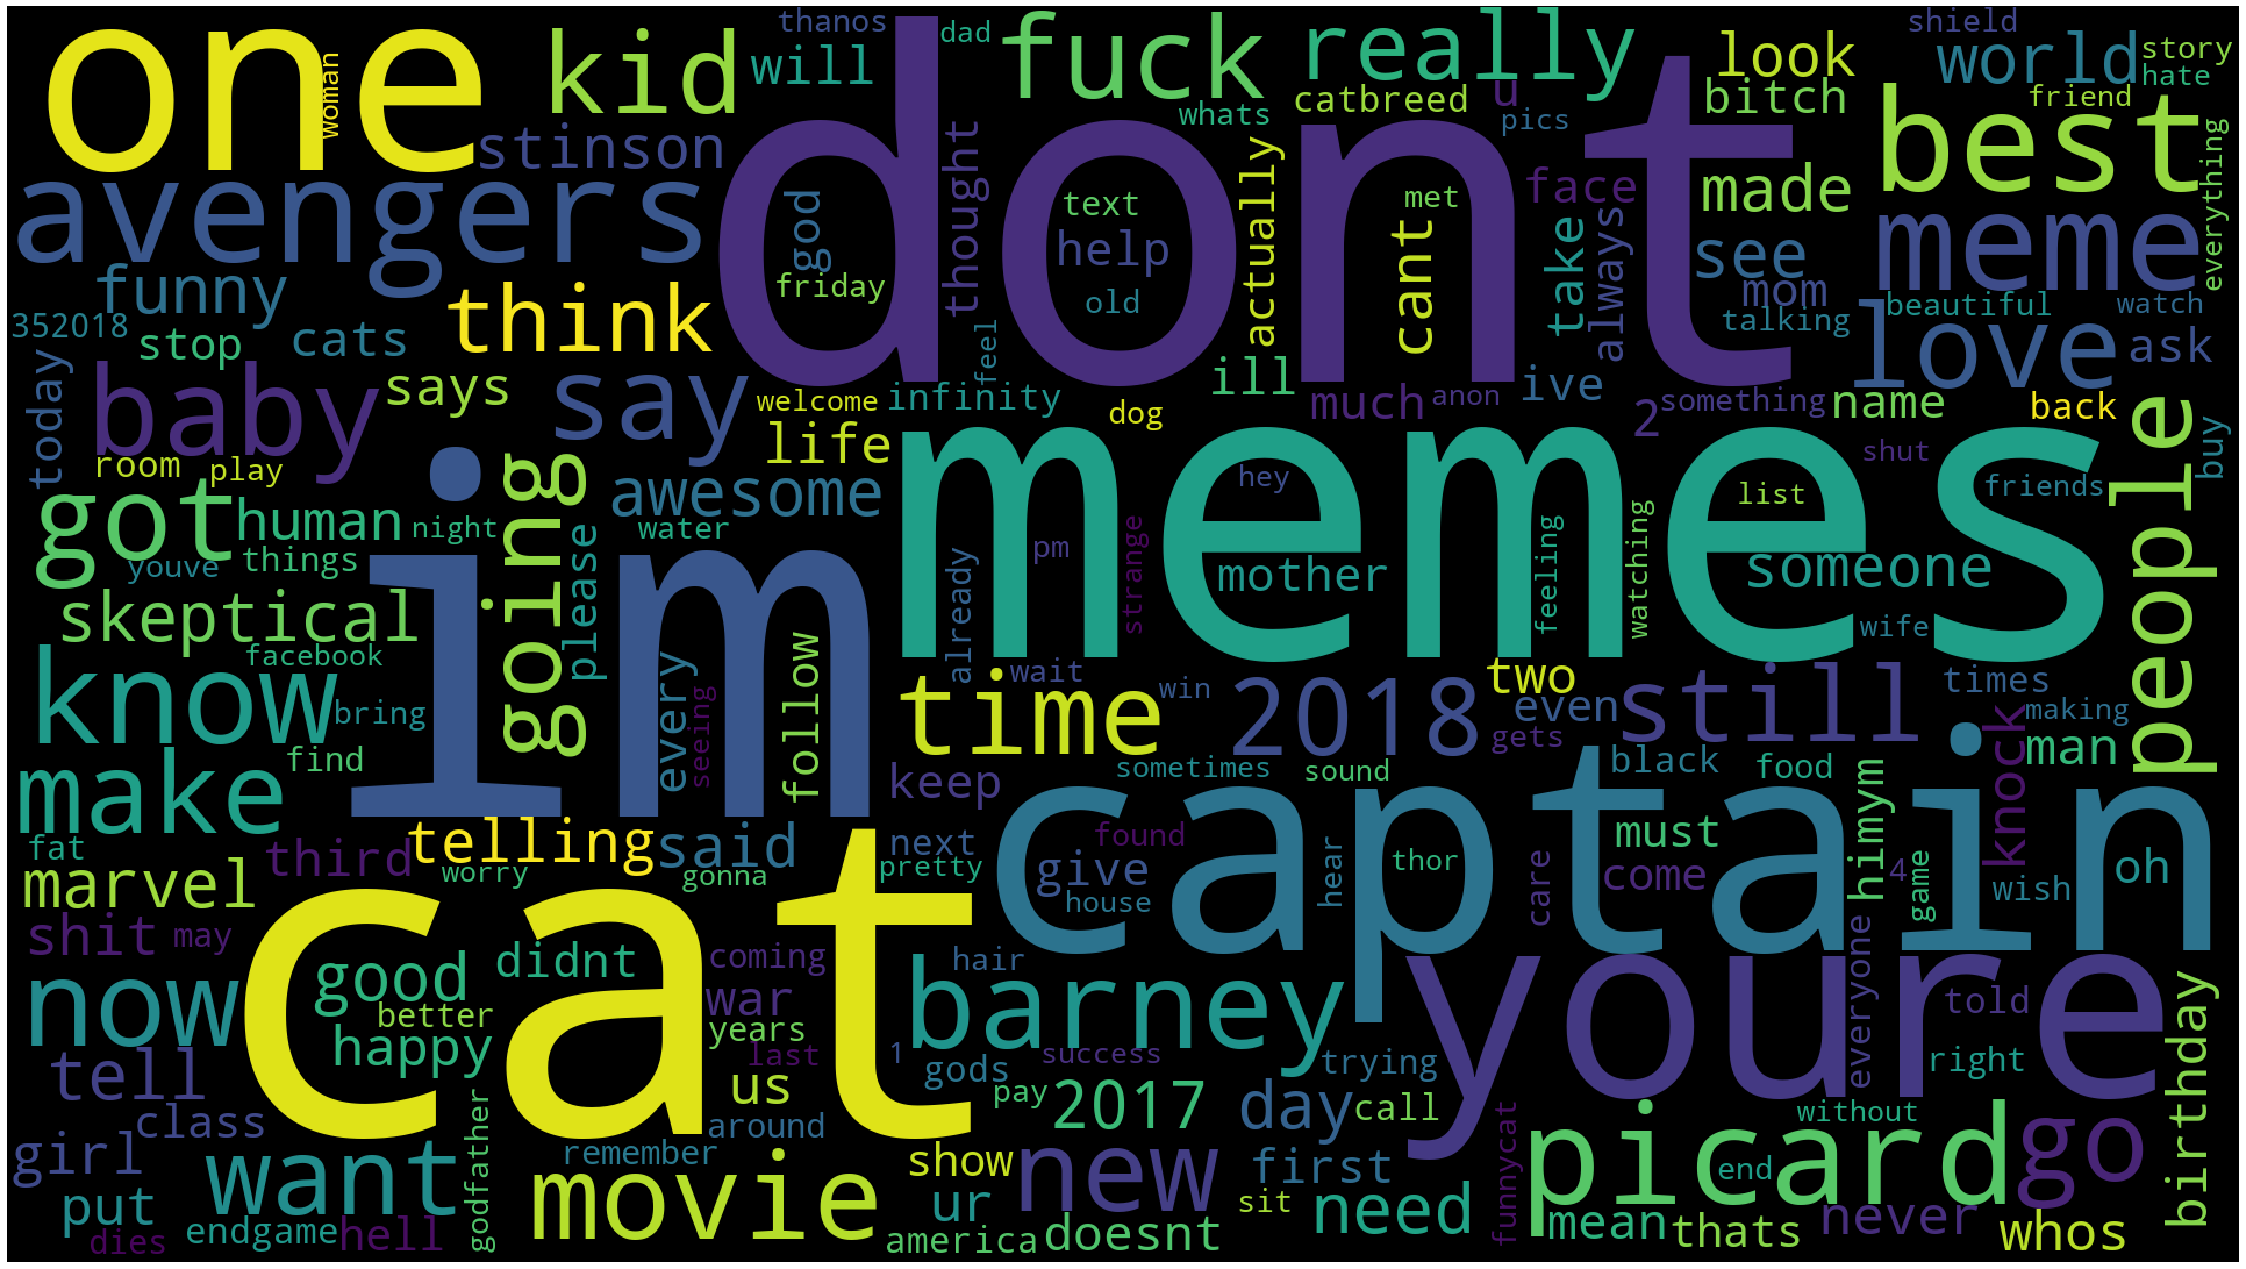

In [26]:
print_cloud(filtered_words)

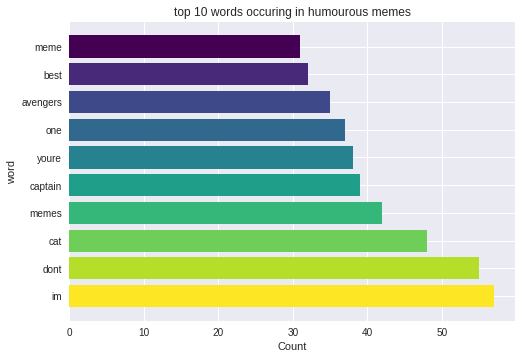

In [27]:
plot_top_n(filtered_words, "top 10 words occuring in humourous memes")

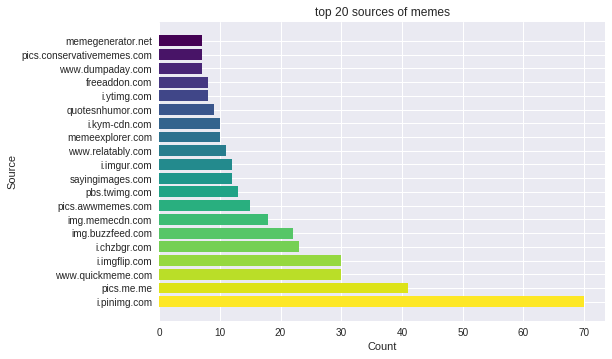

In [28]:
content = dev[dev["Humour"] != "not_funny"].source.values
plot_top_n(content, "top 20 sources of memes", item_name="Source", n=20)

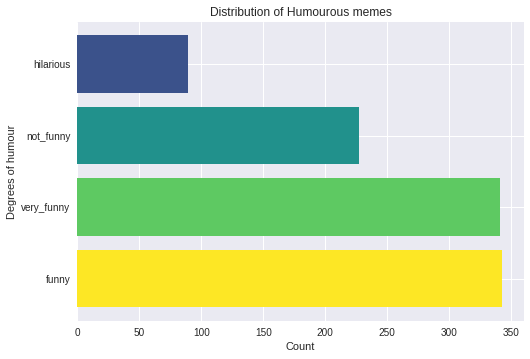

In [29]:
plot_top_n(dev.Humour.values, "Distribution of Humourous memes", item_name="Degrees of humour", n=5)

Text(0.5, 1.0, 'Hilarious')

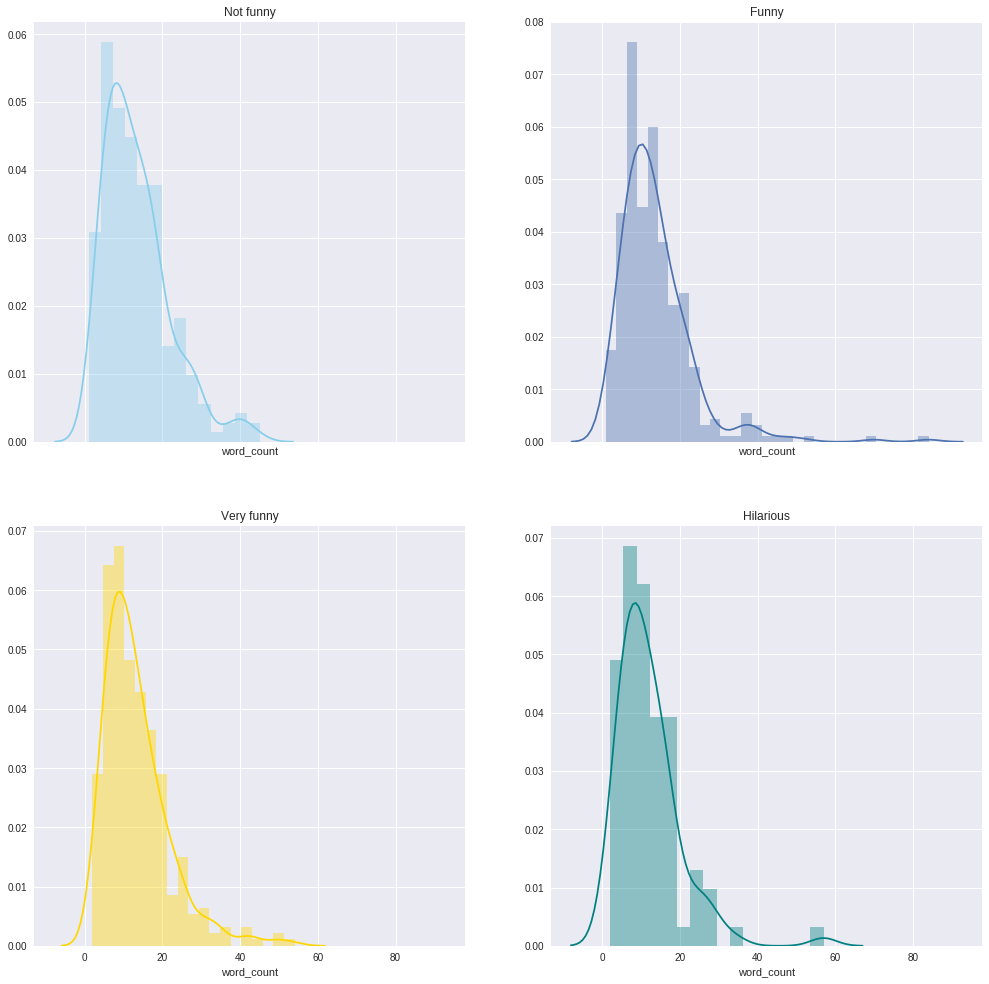

In [30]:
f, axes = plt.subplots(2, 2, figsize=(17, 17), sharex=True)

sns.distplot(dev[dev["Humour"] == "not_funny"]["word_count"] , color="skyblue", ax=axes[0, 0])
axes[0][0].set_title("Not funny")

sns.distplot(dev[dev["Humour"] == "funny"]["word_count"], ax=axes[0, 1])
axes[0][1].set_title("Funny")

sns.distplot(dev[dev["Humour"] == "very_funny"]["word_count"], color="gold", ax=axes[1, 0])
axes[1][0].set_title("Very funny")

sns.distplot(dev[dev["Humour"] == "hilarious"]["word_count"], color="teal", ax=axes[1, 1])
axes[1][1].set_title("Hilarious")

### Sarcasm label

In [31]:
content = ' '.join(dev[dev["Sarcasm"] != "not_sarcastic"].extracted_words)
filtered_words = [word for word in content.split() if word not in STOPWORDS]

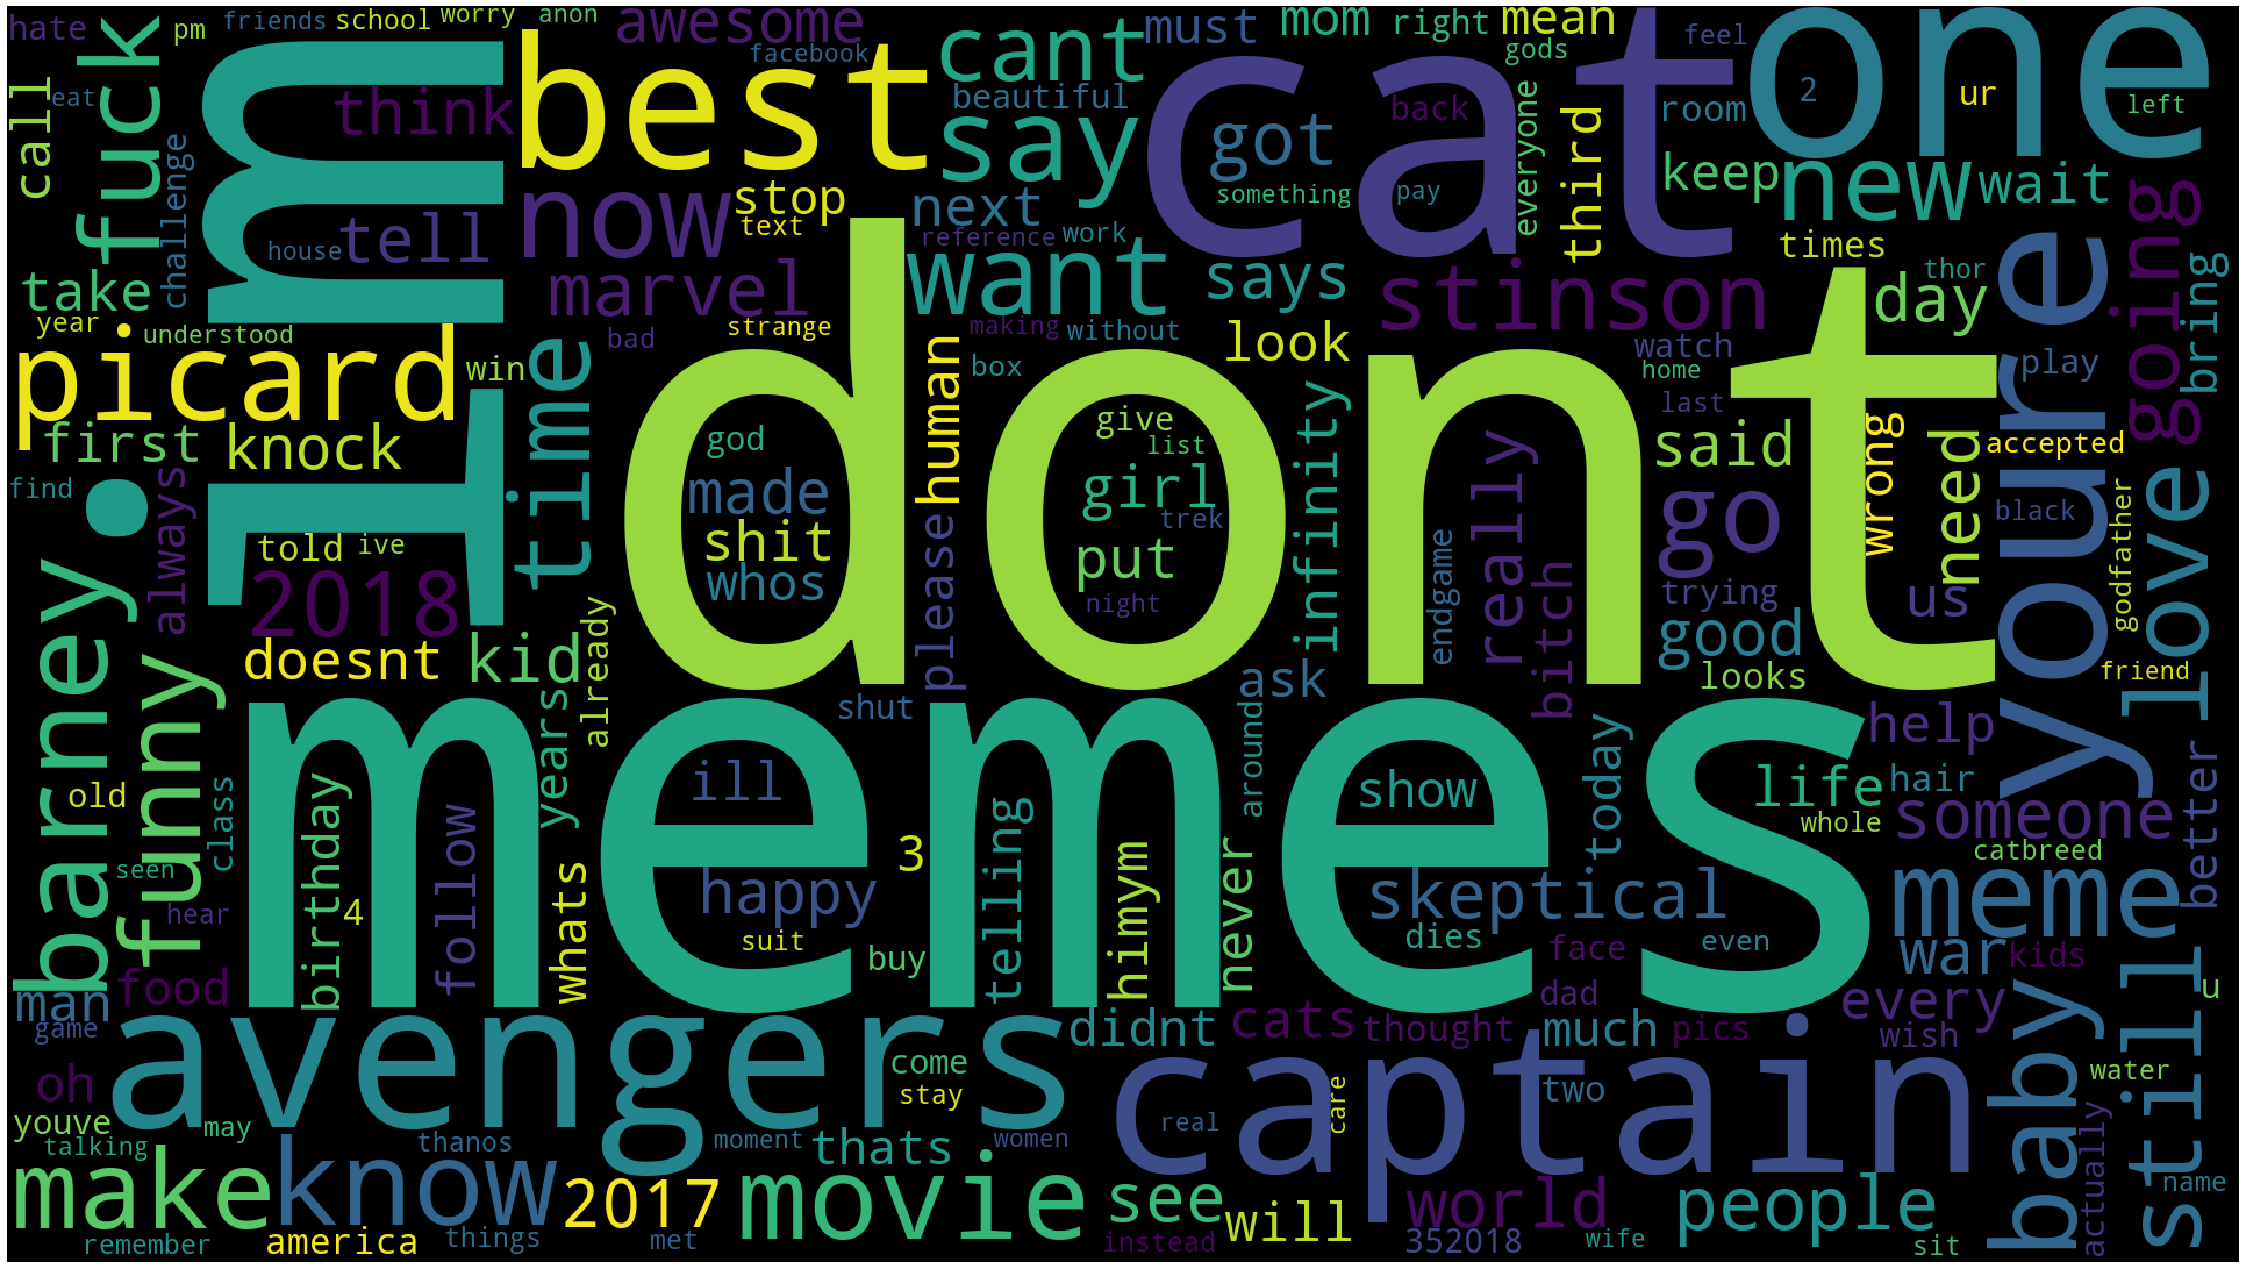

In [32]:
print_cloud(filtered_words)

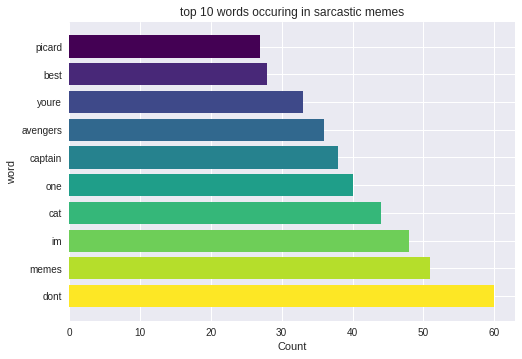

In [33]:
plot_top_n(filtered_words, "top 10 words occuring in sarcastic memes")

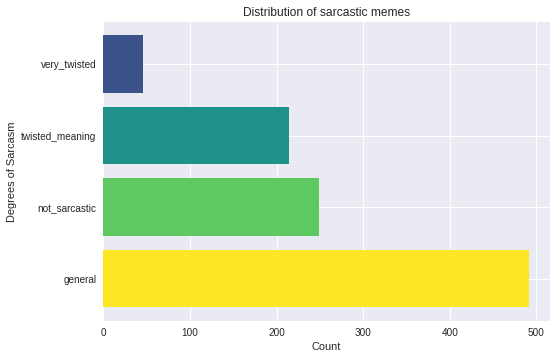

In [34]:
plot_top_n(dev.Sarcasm.values, "Distribution of sarcastic memes", item_name="Degrees of Sarcasm", n=5)

Text(0.5, 1.0, 'Very twisted')

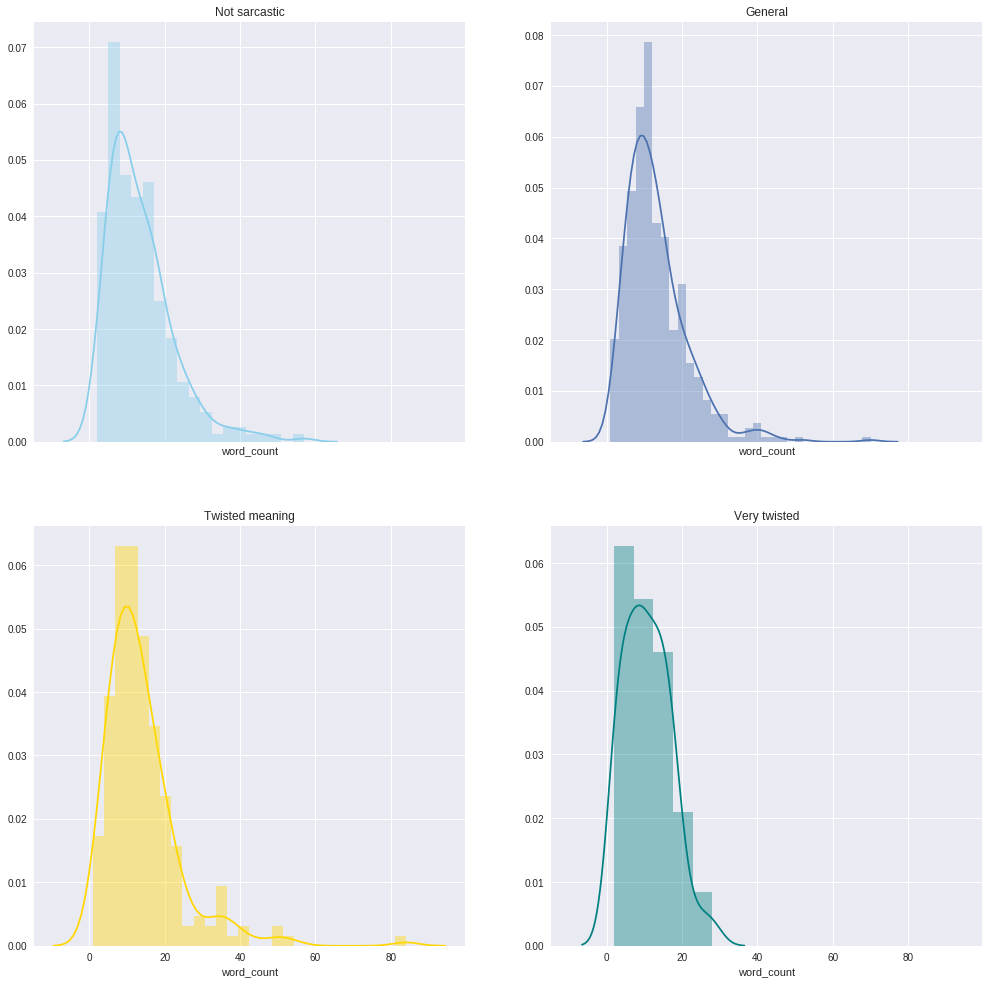

In [35]:
f, axes = plt.subplots(2, 2, figsize=(17, 17), sharex=True)

sns.distplot(dev[dev["Sarcasm"] == "not_sarcastic"]["word_count"] , color="skyblue", ax=axes[0, 0])
axes[0][0].set_title("Not sarcastic")

sns.distplot(dev[dev["Sarcasm"] == "general"]["word_count"], ax=axes[0, 1])
axes[0][1].set_title("General")

sns.distplot(dev[dev["Sarcasm"] == "twisted_meaning"]["word_count"], color="gold", ax=axes[1, 0])
axes[1][0].set_title("Twisted meaning")

sns.distplot(dev[dev["Sarcasm"] == "very_twisted"]["word_count"], color="teal", ax=axes[1, 1])
axes[1][1].set_title("Very twisted")

### Offense label

In [36]:
content = ' '.join(dev[dev["Offense"] != "not_offensive"].extracted_words)
filtered_words = [word for word in content.split() if word not in STOPWORDS]

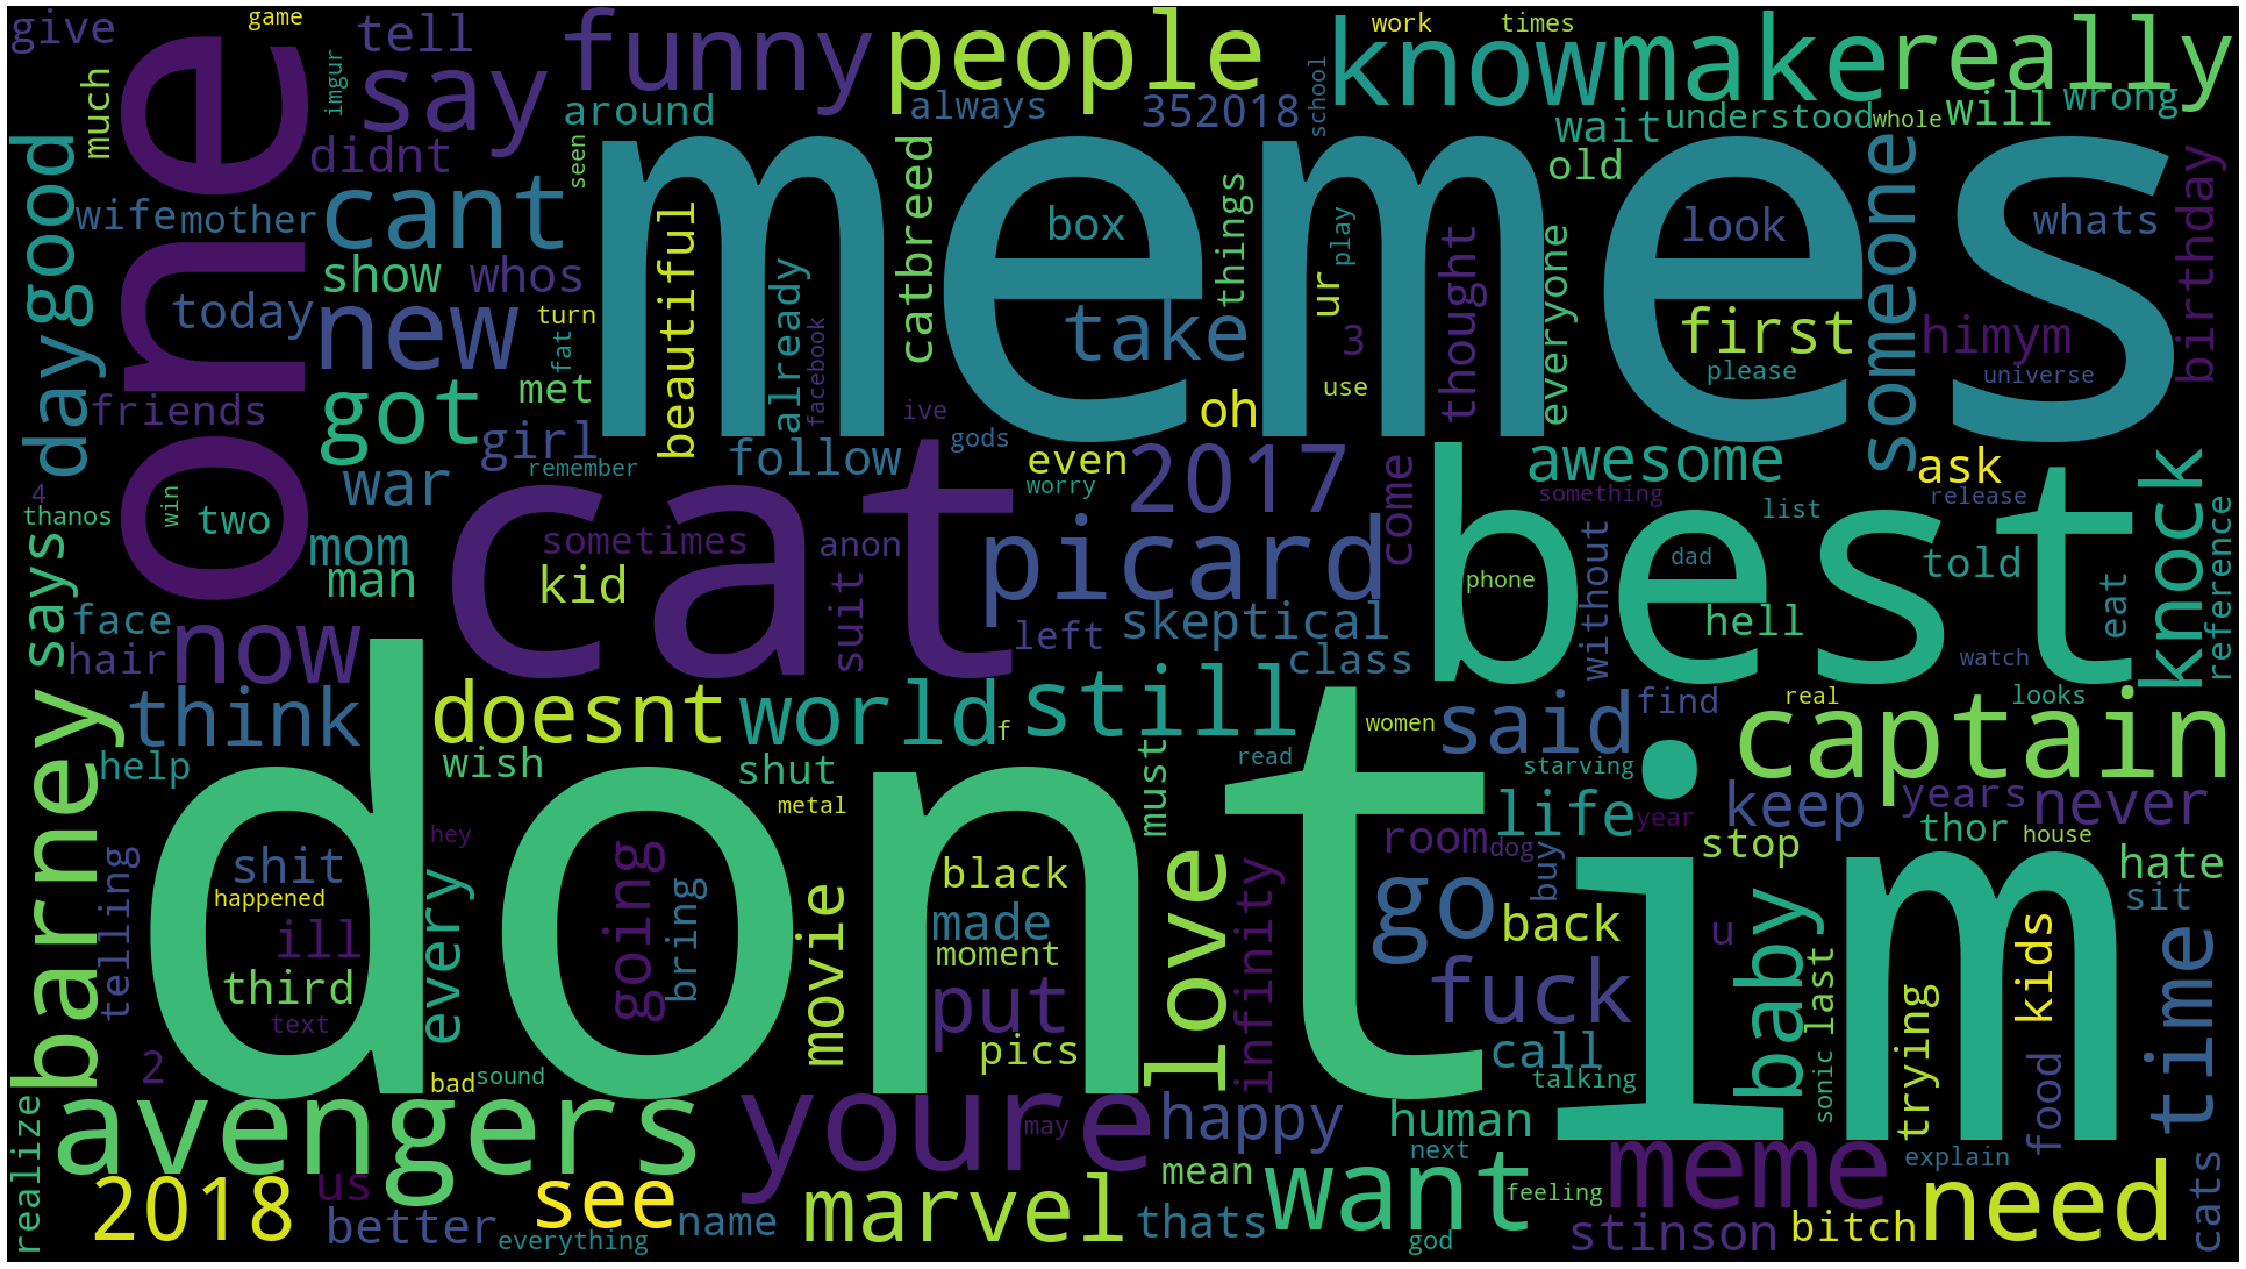

In [37]:
print_cloud(filtered_words)

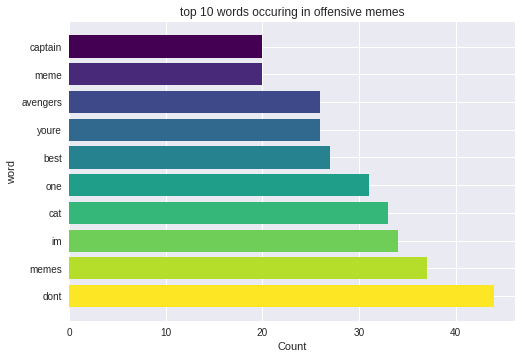

In [38]:
plot_top_n(filtered_words, "top 10 words occuring in offensive memes")

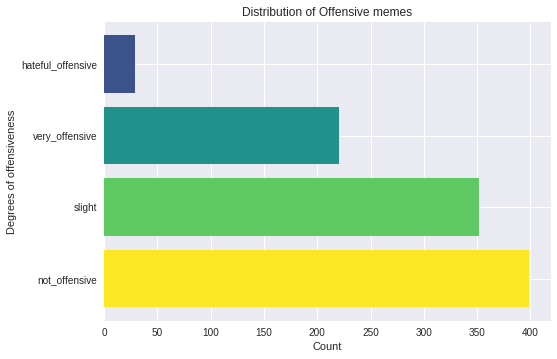

In [39]:
plot_top_n(dev.Offense.values, "Distribution of Offensive memes", item_name="Degrees of offensiveness", n=5)

Text(0.5, 1.0, 'Hateful')

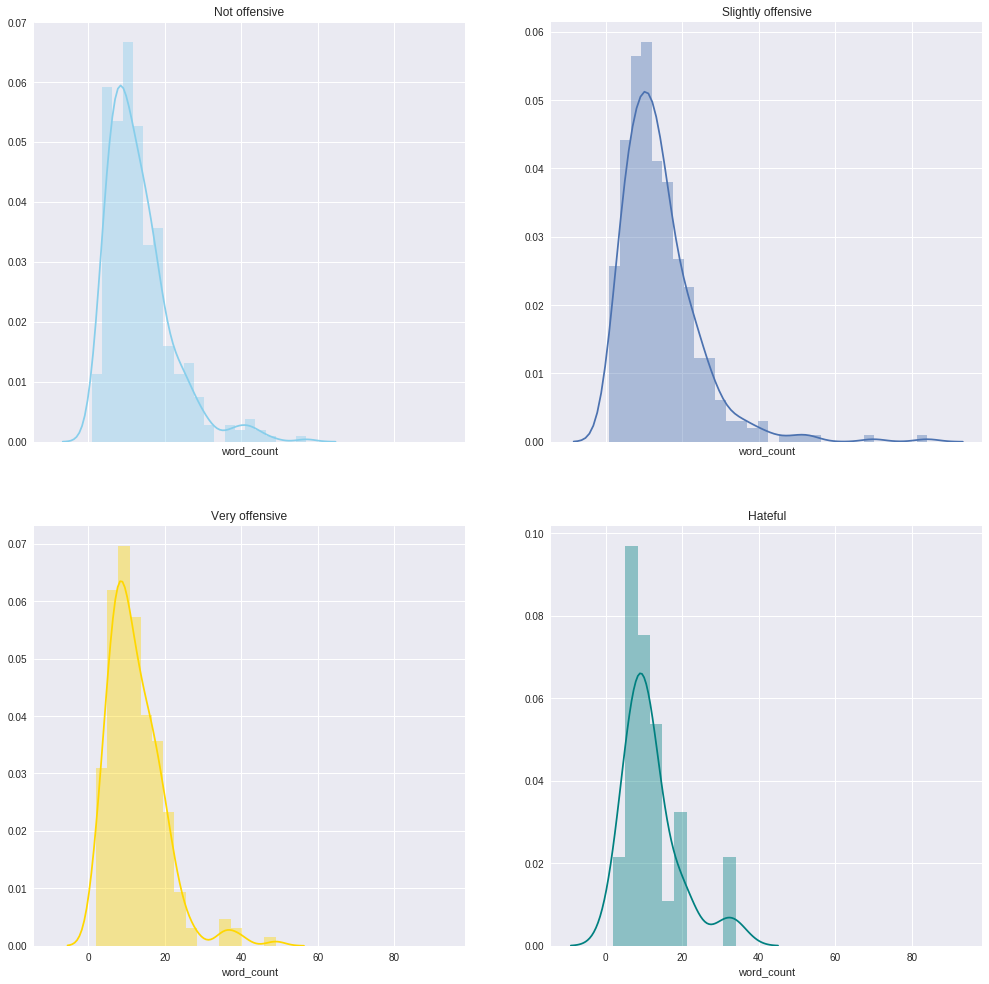

In [40]:
f, axes = plt.subplots(2, 2, figsize=(17, 17), sharex=True)

sns.distplot(dev[dev["Offense"] == "not_offensive"]["word_count"] , color="skyblue", ax=axes[0, 0])
axes[0][0].set_title("Not offensive")

sns.distplot(dev[dev["Offense"] == "slight"]["word_count"], ax=axes[0, 1])
axes[0][1].set_title("Slightly offensive")

sns.distplot(dev[dev["Offense"] == "very_offensive"]["word_count"], color="gold", ax=axes[1, 0])
axes[1][0].set_title("Very offensive")

sns.distplot(dev[dev["Offense"] == "hateful_offensive"]["word_count"], color="teal", ax=axes[1, 1])
axes[1][1].set_title("Hateful")

### Motivational label

In [41]:
content = ' '.join(dev[dev["Motivation"] != "not_motivational"].extracted_words.values)
filtered_words = [word for word in content.split() if word not in STOPWORDS]

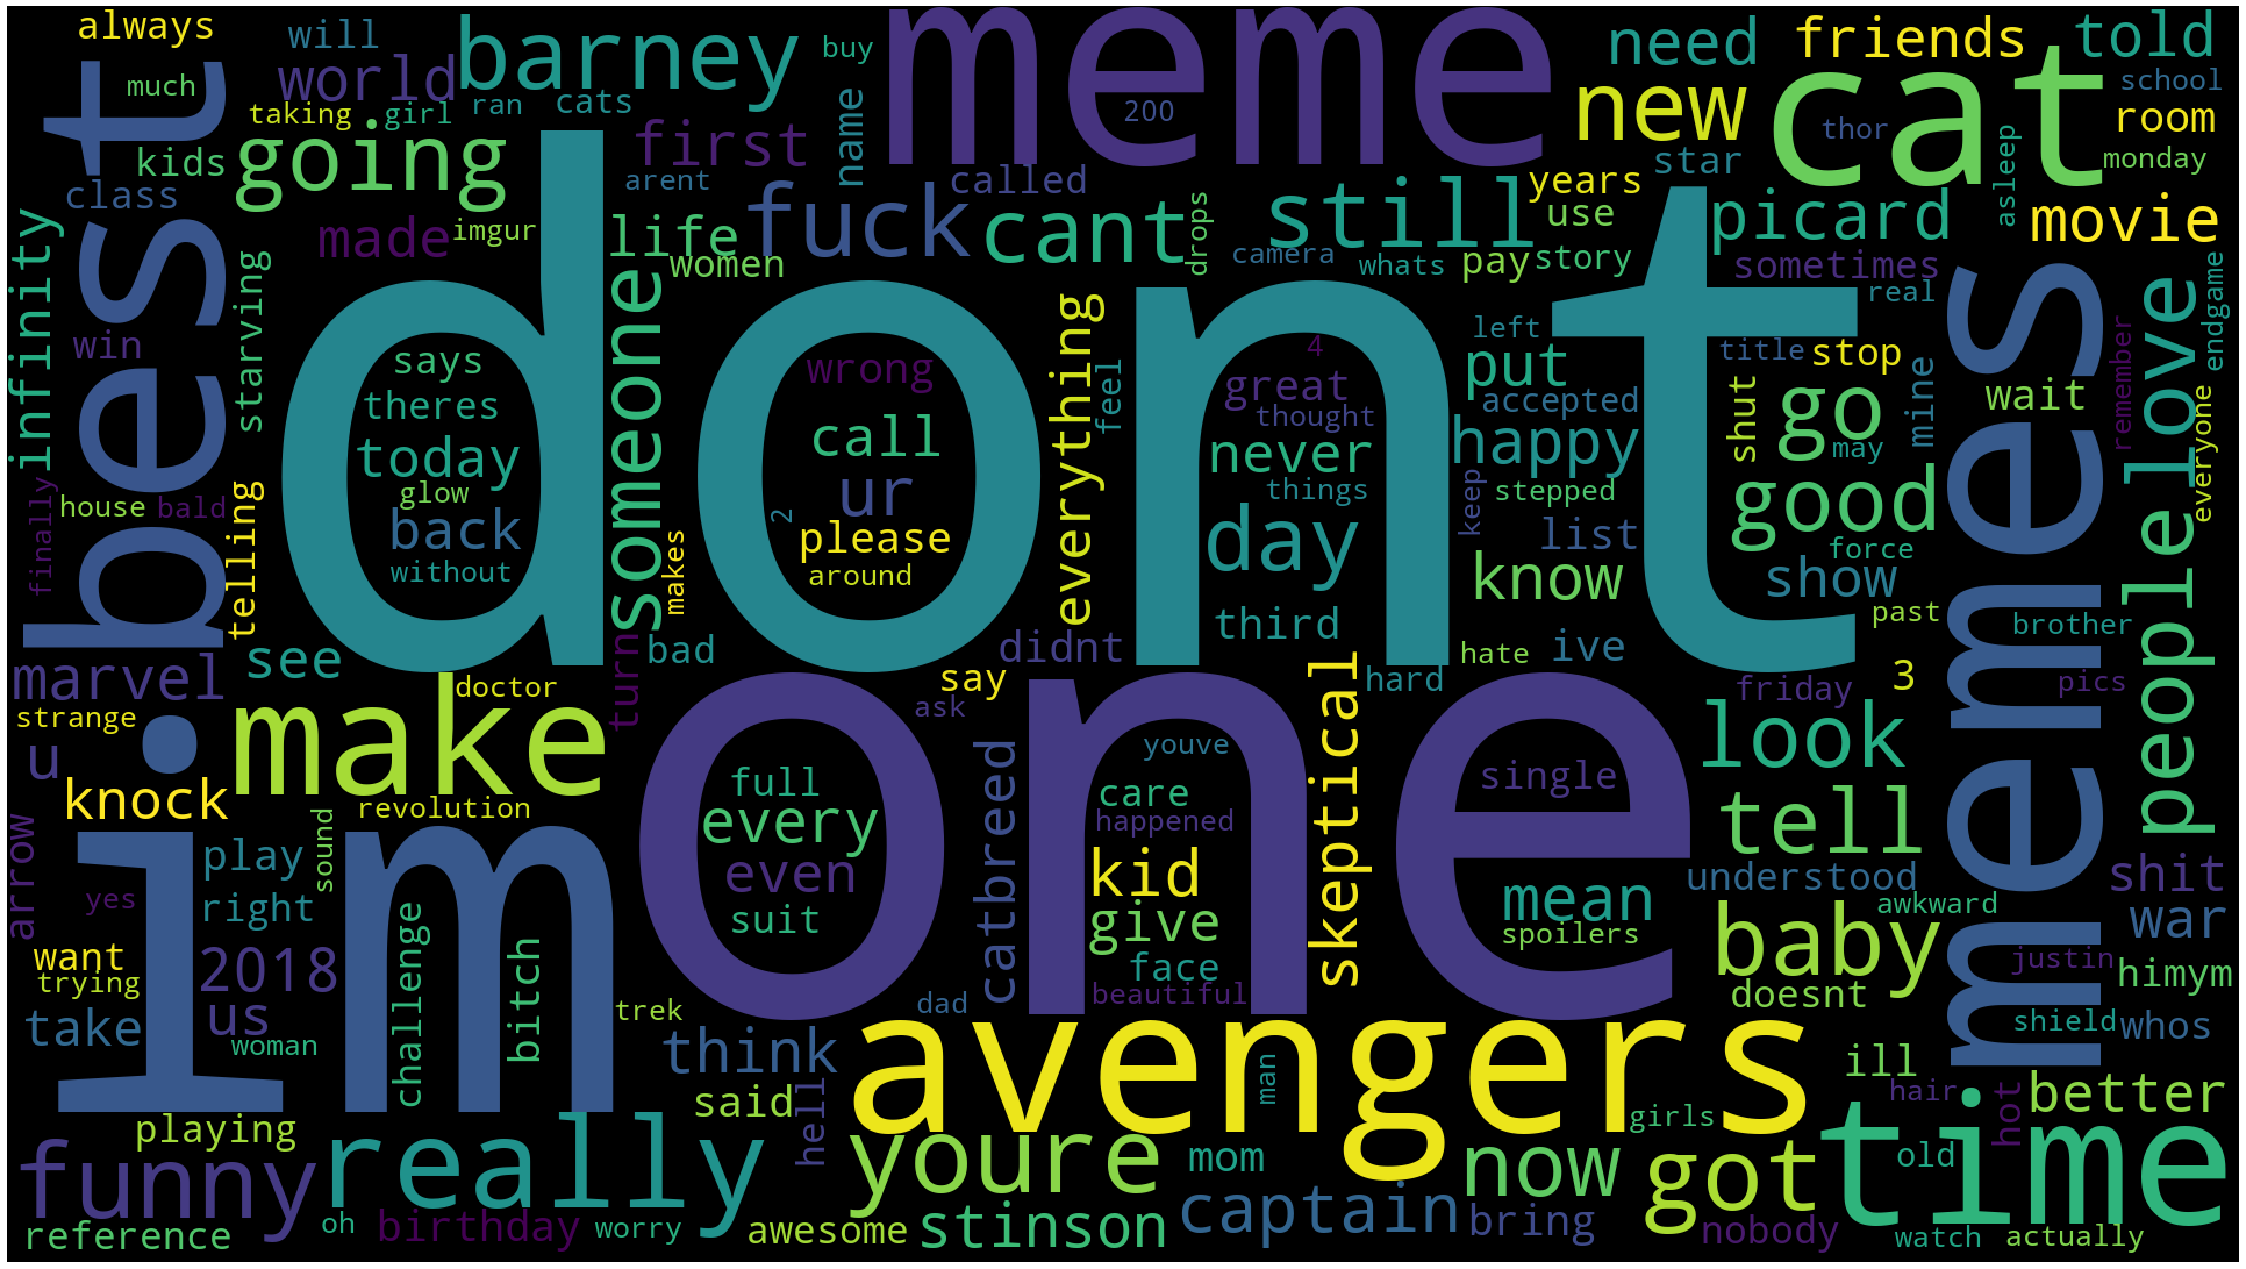

In [42]:
print_cloud(filtered_words)

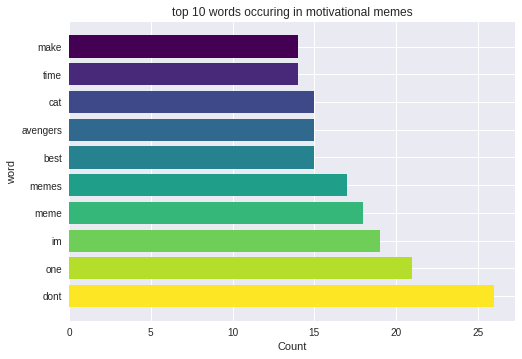

In [43]:
plot_top_n(filtered_words,"top 10 words occuring in motivational memes")

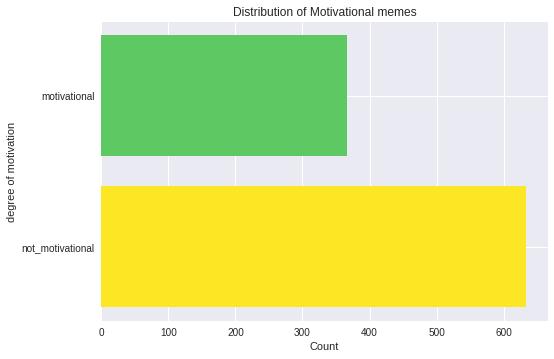

In [44]:
plot_top_n(dev.Motivation.values, "Distribution of Motivational memes", item_name="degree of motivation", n=5)

Text(0.5, 1.0, 'Motivational')

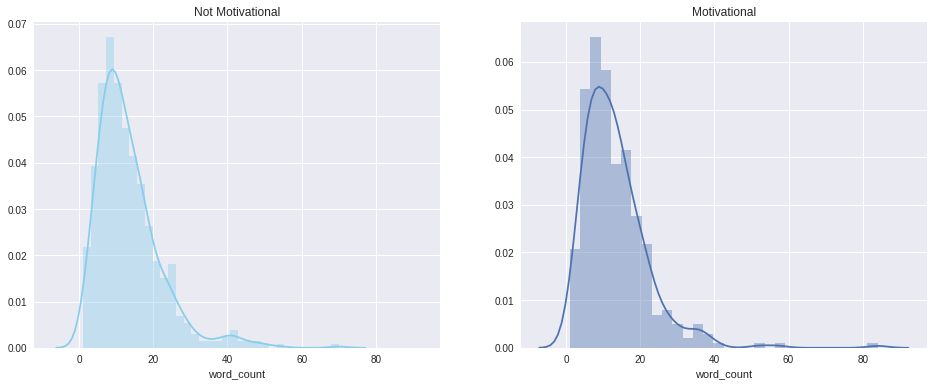

In [45]:
f, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

sns.distplot(dev[dev["Motivation"] == "not_motivational"]["word_count"] , color="skyblue", ax=axes[0])
axes[0].set_title("Not Motivational")

sns.distplot(dev[dev["Motivation"] == "motivational"]["word_count"], ax=axes[1])
axes[1].set_title("Motivational")

### Meme polarity

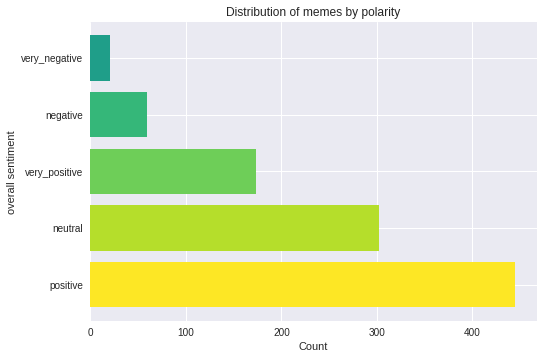

In [46]:
plot_top_n(dev["Overall_sentiment"].values, "Distribution of memes by polarity", item_name="overall sentiment", n=10)

Text(0.5, 1.0, 'Very Positive')

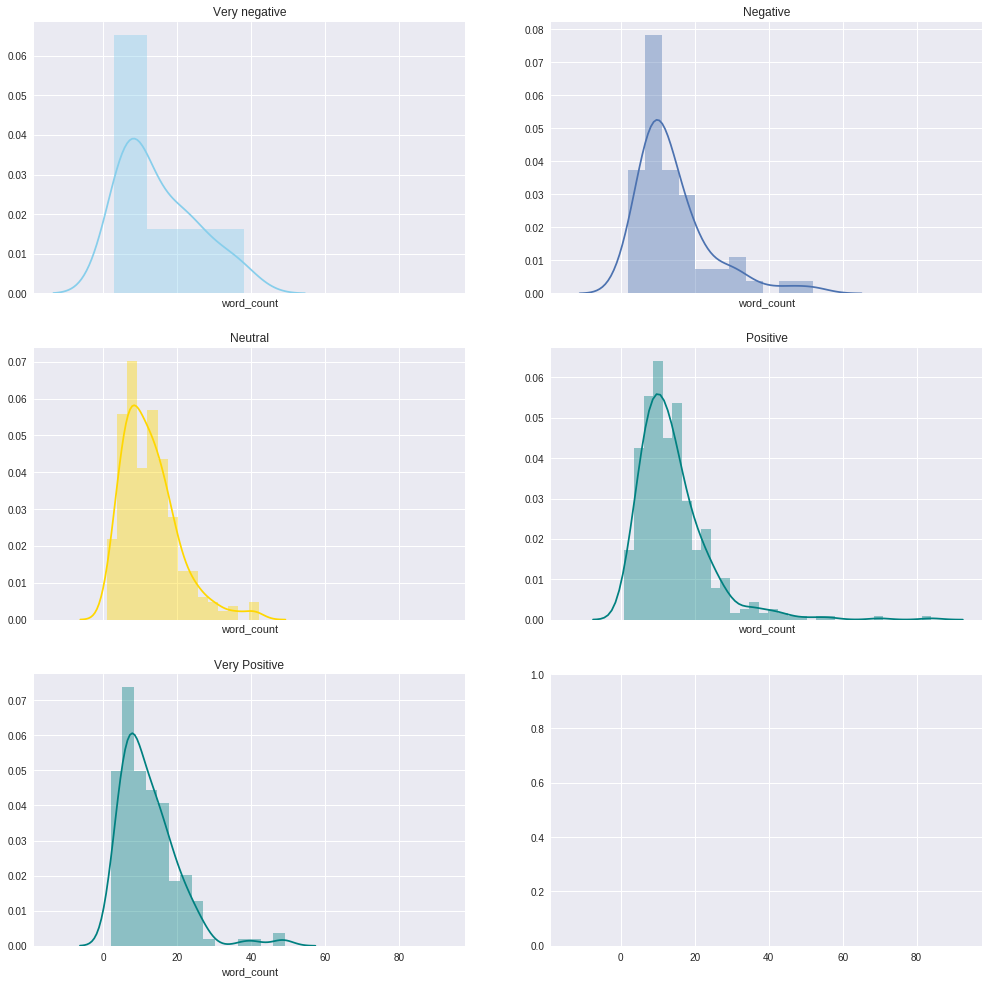

In [47]:
f, axes = plt.subplots(3, 2, figsize=(17, 17), sharex=True)

sns.distplot(dev[dev["Overall_sentiment"] == "very_negative"]["word_count"] , color="skyblue", ax=axes[0, 0])
axes[0][0].set_title("Very negative")

sns.distplot(dev[dev["Overall_sentiment"] == "negative"]["word_count"], ax=axes[0, 1])
axes[0][1].set_title("Negative")

sns.distplot(dev[dev["Overall_sentiment"] == "neutral"]["word_count"], color="gold", ax=axes[1, 0])
axes[1][0].set_title("Neutral")

sns.distplot(dev[dev["Overall_sentiment"] == "positive"]["word_count"], color="teal", ax=axes[1, 1])
axes[1][1].set_title("Positive")

sns.distplot(dev[dev["Overall_sentiment"] == "very_positive"]["word_count"], color="teal", ax=axes[2, 0])
axes[2][0].set_title("Very Positive")